## Housing Price Prediction:
Consider that a real estate company has the data of real estate prices in Delhi. The company wants to optimise the selling price of the properties, based on important factors such as area, bedrooms, parking, etc.


Essentially, the company wants:

- To identify the variables affecting house prices, e.g., area, number of rooms, bathrooms, etc.
- To create a linear model that quantitatively relates house prices with variables, such as the number of rooms, area, number of bathrooms, etc.
- To know the accuracy of the model, i.e. how well do these variables predict the house prices

### Importing libraries

In [1]:
### Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

### Loading Dataset


In [2]:
### Loading dataset
housing = pd.read_csv("Housing.csv")

### Inspecting the dataset


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [4]:
housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [5]:
housing.shape

(545, 13)

### EDA

In [6]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [7]:
### Declaring required vars
numeric_cols = ["price", "area", "bedrooms", "bathrooms", "stories", "parking"]
cat_cols = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea", "furnishingstatus"]
binary_cols = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]


#### Numerical Variable Analysis:

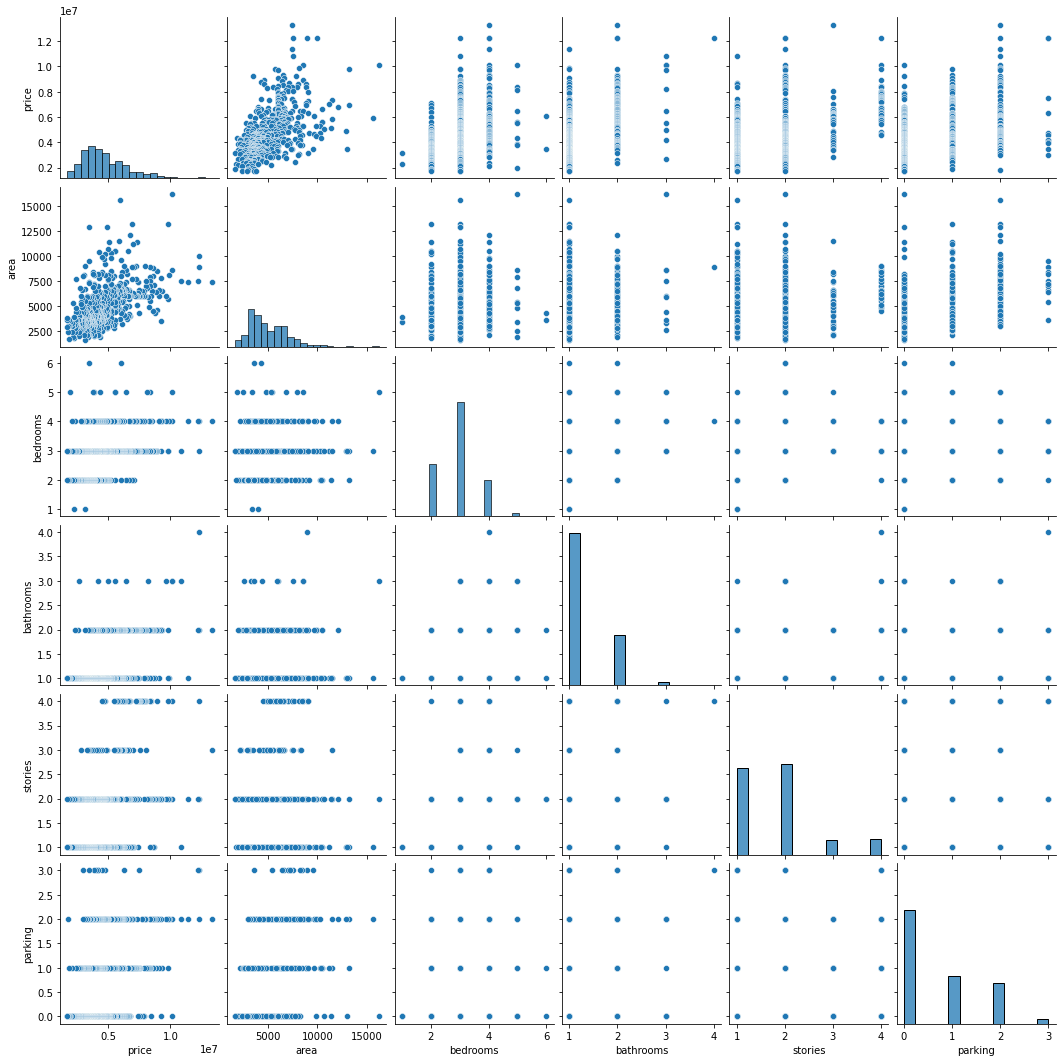

In [8]:
sns.pairplot(housing[numeric_cols])
plt.show()

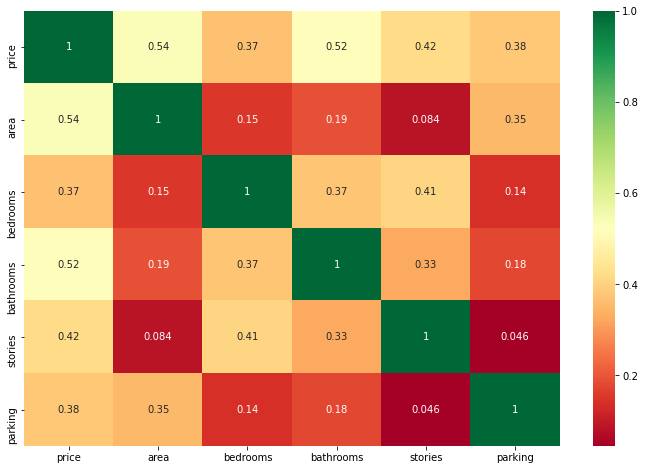

In [9]:
plt.figure(figsize= (12,8))
sns.heatmap(housing[numeric_cols].corr(), annot = True, cmap = 'RdYlGn')
plt.show()

**Observations**
- Area and bathrooms have high correlation with price.


#### Checking for Data Imbalance:

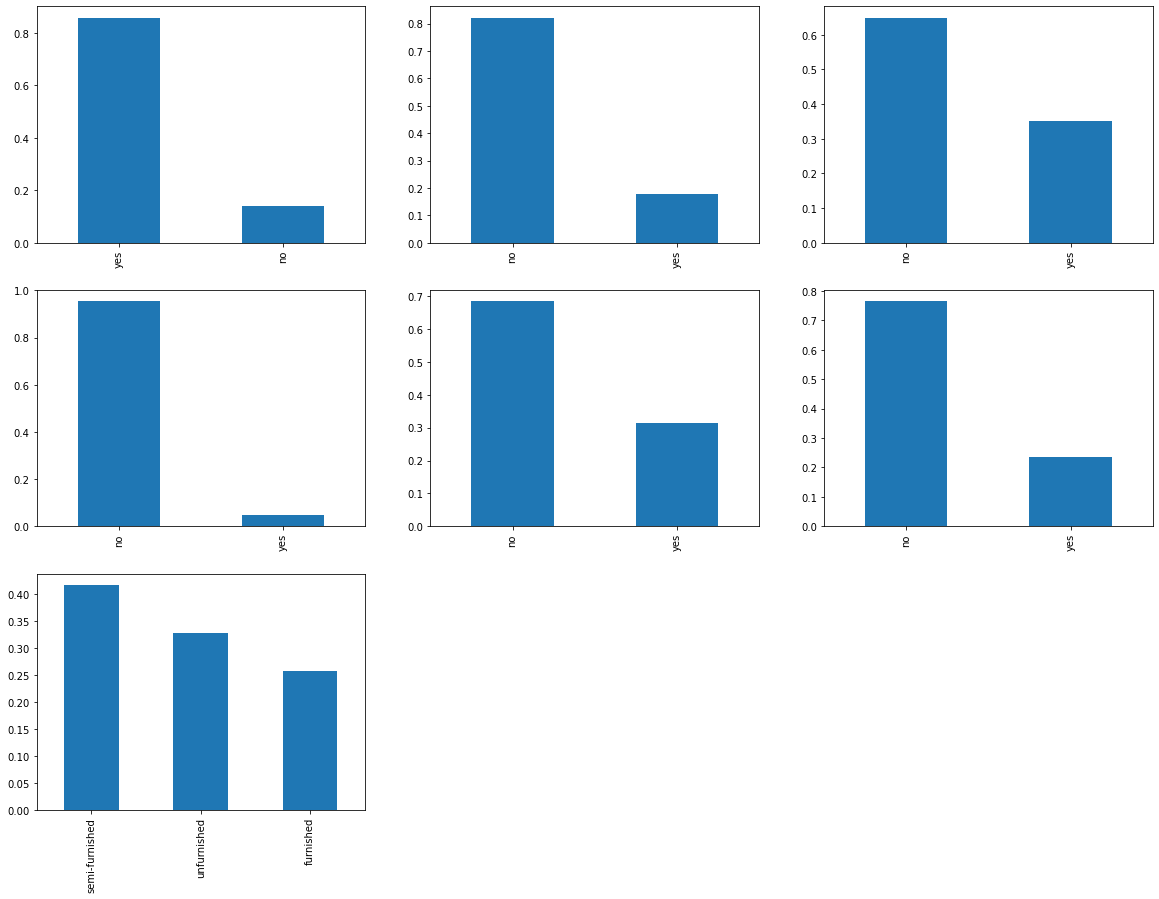

In [10]:
### Checking for class imbalance in categorical variables
index = 1
plt.figure(figsize=(20,20))
for columns in cat_cols:
    plt.subplot(4,3, index)
    housing[columns].value_counts(normalize=True).plot.bar()
    index +=1
plt.show()
    
    

#### Categorical Variable Analysis

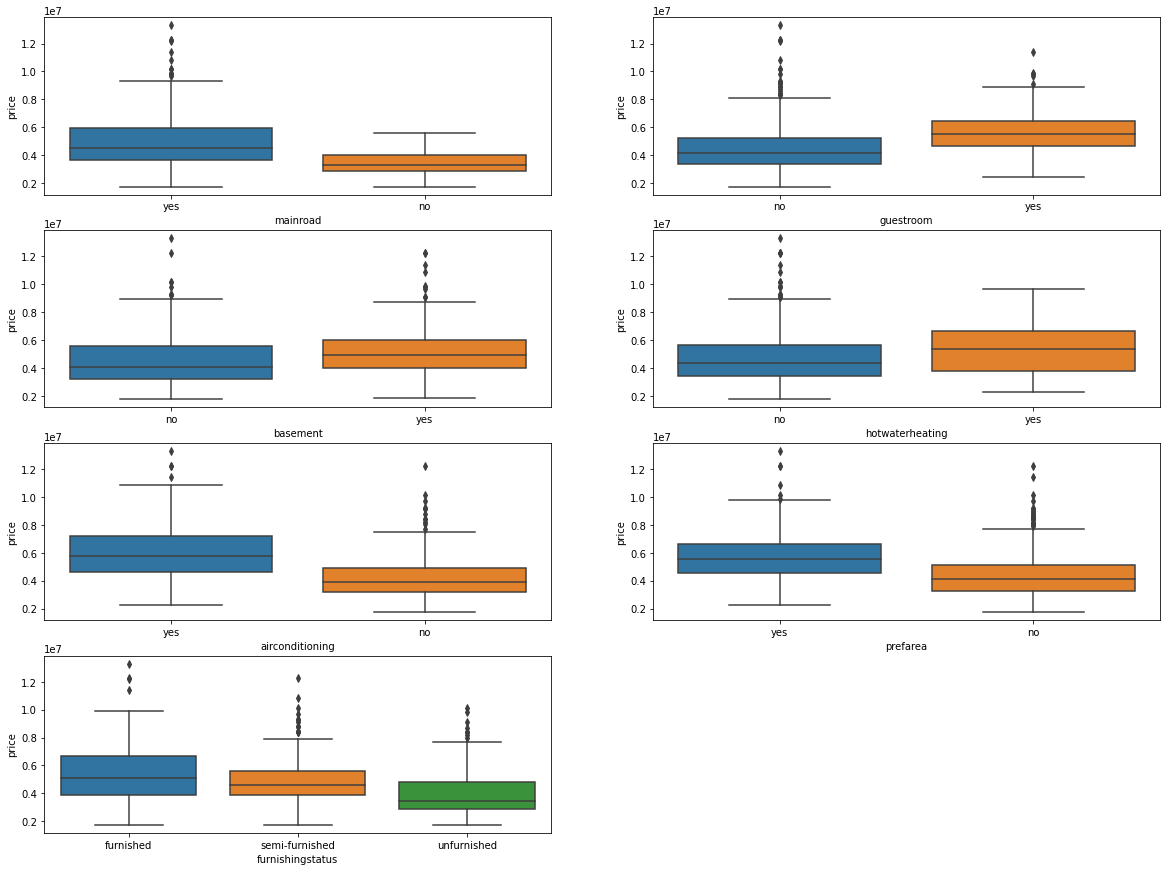

In [11]:
### Categorical variable analysis w.r.t price
index = 1
plt.figure(figsize=(20,15))

for column in cat_cols:
    plt.subplot(4,2, index)
    sns.boxplot(x= column, y = "price", data = housing)
    index+=1
plt.show()
  

<b>Observations:</b>
- Houses with "mainroad", "guestroom", "airconditioning" have higher prices compared to others.
- "Furnished" prices have higher prices compared to others.

### Data Preparation

#### One hot encoding / Dummy Variable Creation


In [12]:
for col in binary_cols:
    housing[col] = housing[col].map({"yes": 1, "no": 0})

In [13]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [14]:
dummy_cols = pd.get_dummies(housing["furnishingstatus"], drop_first = True)
housing = pd.concat([housing, dummy_cols], axis = 1)
housing.drop("furnishingstatus", axis = 1, inplace = True)

In [15]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [16]:
housing.shape

(545, 14)

#### Test Train Split

In [17]:
### Splitting the data to train and test datasets
housing_train, housing_test = train_test_split(housing, train_size = 0.7, random_state = 42)

#### Scaling the variables

In [18]:
### Scaling the required variables

scaler = StandardScaler()
housing_train[numeric_cols] = scaler.fit_transform(housing_train[numeric_cols])
housing_test[numeric_cols] = scaler.transform(housing_test[numeric_cols])


#### Extracting X and Y vars


In [19]:
X_train = housing_train.drop("price", axis = 1)
y_train = housing_train["price"]

X_test = housing_test.drop("price", axis = 1)
y_test = housing_test["price"]

In [20]:
print(housing_train.shape, X_train.shape, y_train.shape)

(381, 14) (381, 13) (381,)


In [21]:
print(housing_test.shape, X_test.shape, y_test.shape)

(164, 14) (164, 13) (164,)


### Model Building:

#### Forward Feature Selection:
As part of this phase, we start building the model with one variable.
Then we keep adding one variable at a time. If the performance of the model increases, we keep it.

Else, we keep adding other variables until we achieve a desirable performance.

In [22]:
### Start the model with the variable "Area".
X_train_sm= housing_train["area"]
X_train_sm = sm.add_constant(X_train_sm)

In [23]:
### Initiating the model, and fitting it
model = OLS(y_train, X_train_sm)
model_fit = model.fit()

model_fit.params

const    3.642919e-17
area     5.513871e-01
dtype: float64

In [24]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     165.6
Date:                Sat, 06 Nov 2021   Prob (F-statistic):           1.10e-31
Time:                        16:49:40   Log-Likelihood:                -471.57
No. Observations:                 381   AIC:                             947.1
Df Residuals:                     379   BIC:                             955.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.643e-17      0.043    8.5e-16      1.000      -0.084       0.084
area           0.5514      0.043     12.867      0.000       0.467       0.636
==============================================================================
Omnibus:                       71.553   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.819
Skew:                           0.988   Prob(JB):                     4.84e-33
Kurtosis:                       5.338   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
### making predictions on the test set.
y_train_pred = model_fit.predict(X_train_sm)
r2_score(y_train, y_train_pred)

0.30402773725485055

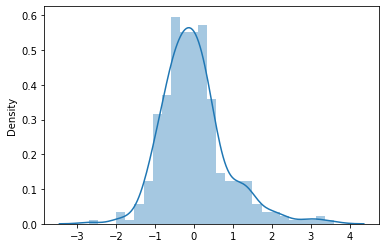

In [26]:
### Checking assumptions of linear regression
res = y_train - y_train_pred
sns.distplot(res)
plt.show()

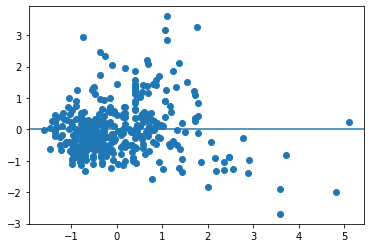

In [27]:
plt.scatter(X_train_sm["area"], res)
plt.axhline(0)

In [28]:
### Next we add both "area", and "bathrooms" in the model.
X_train_sm= housing_train[["area", "bathrooms"]]
X_train_sm = sm.add_constant(X_train_sm)

y_train_sm = housing_train["price"]

In [29]:
model = OLS(y_train_sm, X_train_sm)
model_fit = model.fit()

model_fit.params

const        3.642919e-17
area         4.677808e-01
bathrooms    4.375730e-01
dtype: float64

In [30]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     180.5
Date:                Sat, 06 Nov 2021   Prob (F-statistic):           9.34e-56
Time:                        16:49:40   Log-Likelihood:                -412.90
No. Observations:                 381   AIC:                             831.8
Df Residuals:                     378   BIC:                             843.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.643e-17      0.037    9.9e-16      1.000      -0.072       0.072
area           0.4678      0.037     12.482      0.000       0.394       0.541
bathrooms      0.4376      0.037     11.676      0.000       0.364       0.511
==============================================================================
Omnibus:                       70.504   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.739
Skew:                           0.933   Prob(JB):                     4.59e-36
Kurtosis:                       5.601   Cond. No.                         1.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

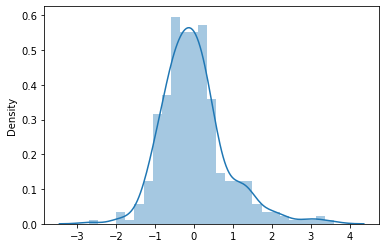

In [31]:
### Checking assumptions of linear regression
res = y_train - y_train_pred
sns.distplot(res)
plt.show()

The model accuracy improved after adding each variable from 28 to 48.<br>
Adding each variable manually is tedious and time-consuming.

#### Backward Feature Selection:
We build the model with all the variables. Every time we build the model, we check for variable significance and VIF values.

We drop the variables based on the following criteria
- High p-value, high VIF - drop the variable
- high p-value, low VIF - we first drop the variables.
- low p-value, high VIF - we then drop these variables

In [32]:
X_train.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
126,0.934301,0.055861,-0.553238,-0.907660,1,0,1,0,0,1.591603,1,0,1
363,-0.710246,-1.274325,-0.553238,-0.907660,1,0,0,1,0,-0.800511,0,1,0
370,-0.390167,-1.274325,-0.553238,-0.907660,1,0,0,0,1,1.591603,0,1,0
31,0.860719,0.055861,-0.553238,2.573733,1,0,0,0,1,1.591603,0,1,0
113,2.065617,0.055861,-0.553238,-0.907660,1,0,1,0,0,1.591603,1,0,0


In [33]:
X_train_sm = sm.add_constant(X_train)

In [34]:
y_train.head()

126    0.630538
363   -0.593759
370   -0.633253
31     2.052301
113    0.745068
Name: price, dtype: float64

In [35]:
model = OLS(y_train, X_train_sm)
model_fit = model.fit()

model_fit.params

const             -0.436989
area               0.310736
bedrooms           0.034310
bathrooms          0.298379
stories            0.202866
mainroad           0.230232
guestroom          0.155554
basement           0.272281
hotwaterheating    0.347754
airconditioning    0.386945
parking            0.142981
prefarea           0.287282
semi-furnished    -0.068635
unfurnished       -0.220707
dtype: float64

In [36]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     63.79
Date:                Sat, 06 Nov 2021   Prob (F-statistic):           1.00e-85
Time:                        16:49:41   Log-Likelihood:                -315.53
No. Observations:                 381   AIC:                             659.1
Df Residuals:                     367   BIC:                             714.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4370      0.106     -4.110      0.000      -0.646      -0.228
area                0.3107      0.033      9.351      0.000       0.245       0.376
bedrooms            0.0343      0.034      0.998      0.319      -0.033       0.102
bathrooms           0.2984      0.033      9.031      0.000       0.233       0.363
stories             0.2029      0.036      5.599      0.000       0.132       0.274
mainroad            0.2302      0.091      2.517      0.012       0.050       0.410
guestroom           0.1556      0.084      1.858      0.064      -0.009       0.320
basement            0.2723      0.072      3.794      0.000       0.131       0.413
hotwaterheating     0.3478      0.133      2.619      0.009       0.087       0.609
airconditioning     0.3869      0.070      5.502      0.000       0.249       0.525
parking             0.1430      0.031      4.547      0.000       0.081       0.205
prefarea            0.2873      0.073      3.925      0.000       0.143       0.431
semi-furnished     -0.0686      0.073     -0.941      0.347      -0.212       0.075
unfurnished        -0.2207      0.081     -2.741      0.006      -0.379      -0.062
==============================================================================
Omnibus:                       61.032   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.413
Skew:                           0.805   Prob(JB):                     4.38e-32
Kurtosis:                       5.550   Cond. No.                         7.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
vif = pd.DataFrame()
vif["Columns"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif

,Columns,VIF
0,area,1.271264
1,bedrooms,1.410728
2,bathrooms,1.305461
3,stories,1.567784
4,mainroad,3.779996
5,guestroom,1.560473
6,basement,2.166658
7,hotwaterheating,1.087731
8,airconditioning,1.782456
9,parking,1.178848


In [38]:
#### Removing Semi-furnished variable
X_train_sm.drop("semi-furnished", axis = 1, inplace = True)

In [39]:
model = OLS(y_train, X_train_sm)
model_fit = model.fit()

model_fit.params

const             -0.486776
area               0.311758
bedrooms           0.033811
bathrooms          0.298009
stories            0.205440
mainroad           0.234667
guestroom          0.154988
basement           0.274393
hotwaterheating    0.348969
airconditioning    0.392799
parking            0.143826
prefarea           0.287893
unfurnished       -0.175917
dtype: float64

In [40]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     69.05
Date:                Sat, 06 Nov 2021   Prob (F-statistic):           1.83e-86
Time:                        16:49:41   Log-Likelihood:                -315.99
No. Observations:                 381   AIC:                             658.0
Df Residuals:                     368   BIC:                             709.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4868      0.092     -5.279      0.000      -0.668      -0.305
area                0.3118      0.033      9.388      0.000       0.246       0.377
bedrooms            0.0338      0.034      0.983      0.326      -0.034       0.101
bathrooms           0.2980      0.033      9.022      0.000       0.233       0.363
stories             0.2054      0.036      5.688      0.000       0.134       0.276
mainroad            0.2347      0.091      2.570      0.011       0.055       0.414
guestroom           0.1550      0.084      1.851      0.065      -0.010       0.320
basement            0.2744      0.072      3.826      0.000       0.133       0.415
hotwaterheating     0.3490      0.133      2.628      0.009       0.088       0.610
airconditioning     0.3928      0.070      5.608      0.000       0.255       0.531
parking             0.1438      0.031      4.576      0.000       0.082       0.206
prefarea            0.2879      0.073      3.935      0.000       0.144       0.432
unfurnished        -0.1759      0.065     -2.709      0.007      -0.304      -0.048
==============================================================================
Omnibus:                       62.361   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.914
Skew:                           0.821   Prob(JB):                     7.60e-33
Kurtosis:                       5.573   Cond. No.                         7.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
vif = pd.DataFrame()
vif["Columns"] = X_train_sm.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train_sm.columns))]
vif

,Columns,VIF
0,const,1.271264
1,area,1.410728
2,bedrooms,1.305461
3,bathrooms,1.567784
4,stories,3.779996
5,mainroad,1.560473
6,guestroom,2.166658
7,basement,1.087731
8,hotwaterheating,1.782456
9,airconditioning,1.178848


In [42]:
X_train_sm.drop("bedrooms", axis = 1, inplace = True)

model = OLS(y_train, X_train_sm)
model_fit = model.fit()

model_fit.params

const             -0.480418
area               0.314325
bathrooms          0.306384
stories            0.217395
mainroad           0.223305
guestroom          0.151481
basement           0.284284
hotwaterheating    0.349666
airconditioning    0.394854
parking            0.146144
prefarea           0.290220
unfurnished       -0.178141
dtype: float64

In [43]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     75.24
Date:                Sat, 06 Nov 2021   Prob (F-statistic):           3.31e-87
Time:                        16:49:41   Log-Likelihood:                -316.49
No. Observations:                 381   AIC:                             657.0
Df Residuals:                     369   BIC:                             704.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4804      0.092     -5.223      0.000      -0.661      -0.300
area                0.3143      0.033      9.496      0.000       0.249       0.379
bathrooms           0.3064      0.032      9.601      0.000       0.244       0.369
stories             0.2174      0.034      6.392      0.000       0.151       0.284
mainroad            0.2233      0.091      2.465      0.014       0.045       0.401
guestroom           0.1515      0.084      1.811      0.071      -0.013       0.316
basement            0.2843      0.071      4.004      0.000       0.145       0.424
hotwaterheating     0.3497      0.133      2.634      0.009       0.089       0.611
airconditioning     0.3949      0.070      5.640      0.000       0.257       0.533
parking             0.1461      0.031      4.664      0.000       0.085       0.208
prefarea            0.2902      0.073      3.969      0.000       0.146       0.434
unfurnished        -0.1781      0.065     -2.745      0.006      -0.306      -0.051
==============================================================================
Omnibus:                       65.541   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.295
Skew:                           0.845   Prob(JB):                     5.73e-36
Kurtosis:                       5.714   Cond. No.                         7.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
vif = pd.DataFrame()
vif["Columns"] = X_train_sm.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train_sm.columns))]
vif

,Columns,VIF
0,const,1.271264
1,area,1.410728
2,bathrooms,1.305461
3,stories,1.567784
4,mainroad,3.779996
5,guestroom,1.560473
6,basement,2.166658
7,hotwaterheating,1.087731
8,airconditioning,1.782456
9,parking,1.178848


In [45]:
X_train_sm.drop("guestroom", axis = 1, inplace = True)

model = OLS(y_train, X_train_sm)
model_fit = model.fit()

model_fit.params

const             -0.472629
area               0.322035
bathrooms          0.304805
stories            0.224663
mainroad           0.225055
basement           0.332832
hotwaterheating    0.341200
airconditioning    0.400040
parking            0.142616
prefarea           0.299635
unfurnished       -0.184453
dtype: float64

In [46]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     81.94
Date:                Sat, 06 Nov 2021   Prob (F-statistic):           1.79e-87
Time:                        16:49:41   Log-Likelihood:                -318.17
No. Observations:                 381   AIC:                             658.3
Df Residuals:                     370   BIC:                             701.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4726      0.092     -5.128      0.000      -0.654      -0.291
area                0.3220      0.033      9.780      0.000       0.257       0.387
bathrooms           0.3048      0.032      9.525      0.000       0.242       0.368
stories             0.2247      0.034      6.631      0.000       0.158       0.291
mainroad            0.2251      0.091      2.477      0.014       0.046       0.404
basement            0.3328      0.066      5.046      0.000       0.203       0.463
hotwaterheating     0.3412      0.133      2.564      0.011       0.080       0.603
airconditioning     0.4000      0.070      5.701      0.000       0.262       0.538
parking             0.1426      0.031      4.546      0.000       0.081       0.204
prefarea            0.2996      0.073      4.095      0.000       0.156       0.444
unfurnished        -0.1845      0.065     -2.837      0.005      -0.312      -0.057
==============================================================================
Omnibus:                       65.759   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.056
Skew:                           0.839   Prob(JB):                     5.30e-37
Kurtosis:                       5.776   Cond. No.                         7.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
vif = pd.DataFrame()
vif["Columns"] = X_train_sm.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train_sm.columns))]
vif

,Columns,VIF
0,const,1.271264
1,area,1.410728
2,bathrooms,1.305461
3,stories,1.567784
4,mainroad,3.779996
5,basement,1.560473
6,hotwaterheating,2.166658
7,airconditioning,1.087731
8,parking,1.782456
9,prefarea,1.178848


In [48]:
#### Getting predictions
y_train_pred = model_fit.predict(X_train_sm)
r2_score(y_train, y_train_pred)

0.6889090508822316

In [49]:
cols = X_train_sm.columns
X_test_sm = sm.add_constant(X_test)
X_test_sm = X_test_sm[cols]

In [50]:
y_test_pred = model_fit.predict(X_test_sm)
r2_score(y_test, y_test_pred)

0.6426835916967768

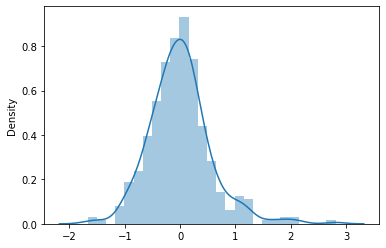

In [51]:
#### Checking the predictions of the model
res = y_train - y_train_pred
sns.distplot(res)
plt.show()

#### Using RFE to select the significant features:

In [52]:
lr = LinearRegression()
rfe = RFE(lr, 10)

rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [53]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_ ))

[('area', True, 1),
 ('bedrooms', False, 4),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', True, 1),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', False, 2),
 ('prefarea', True, 1),
 ('semi-furnished', False, 3),
 ('unfurnished', True, 1)]

In [54]:
rfe_cols = X_train.columns[rfe.support_]
rfe_cols

Index(['area', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement',
       'hotwaterheating', 'airconditioning', 'prefarea', 'unfurnished'],
      dtype='object')

In [55]:
X_train_modif = X_train[rfe_cols]

lr = LinearRegression()
lr_model = lr.fit(X_train_modif, y_train)

In [56]:
y_train_pred = lr_model.predict(X_train_modif)
r2_score(y_train, y_train_pred)

0.6734761671835725

In [57]:
### Getting the predictions of the model

X_test = X_test[rfe_cols]

y_test_pred = lr_model.predict(X_test)
r2_score(y_test, y_test_pred)

0.6415224459618363

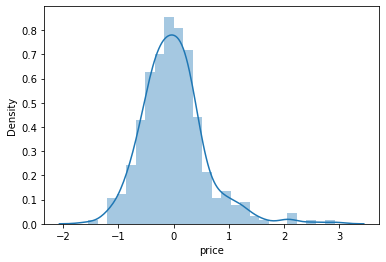

In [58]:
res = y_train - y_train_pred
sns.distplot(res)
plt.show()

### Conclusion:
We have built a model with an accuracy score of 68%. But there could be a chance of improving the model
- we can try adding the additional features to improve the model.
- Use regularisation techniques 